<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/IMDB_Dataset_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [2]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import keras_tuner as kt


PARAMETERS

In [4]:
# Parameter
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


MODEL FUNCTION FOR KERAS TUNER

In [5]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=num_words,
                                output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
                                input_length=maxlen))
    model.add(layers.Bidirectional(layers.SimpleRNN(
        units=hp.Choice('rnn_units', [32, 64, 128]),
        return_sequences=True)))
    model.add(layers.Bidirectional(layers.SimpleRNN(
        units=hp.Choice('rnn_units2', [32, 64]),
        return_sequences=False)))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(hp.Choice('dense_units', [64, 128]), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate2', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

HYPERPARAMETER TUNING

In [6]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='deep_rnn_imdb')

tuner.search(x_train, y_train,
             epochs=5,
             validation_split=0.2,
             batch_size=64)



Trial 5 Complete [00h 05m 59s]
val_accuracy: 0.7990000247955322

Best val_accuracy So Far: 0.7990000247955322
Total elapsed time: 00h 29m 56s


GET BEST MODEL

In [11]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.5,
    verbose=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.5080 - loss: 0.7157 - val_accuracy: 0.6566 - val_loss: 0.6272
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.7106 - loss: 0.5773 - val_accuracy: 0.7702 - val_loss: 0.4975
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 0.8372 - loss: 0.3894 - val_accuracy: 0.7726 - val_loss: 0.4917
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.8996 - loss: 0.2586 - val_accuracy: 0.7964 - val_loss: 0.5126
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 287ms/step - accuracy: 0.9578 - loss: 0.1240 - val_accuracy: 0.6686 - val_loss: 0.7776
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - accuracy: 0.9581 - loss: 0.1140 - val_accuracy: 0.7545 - val_loss: 0.8527
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.9910 - loss: 0.0271 - val_accuracy: 0.7595 - val_loss: 1.0866
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.9861 - loss: 0.0437 - val_accuracy: 0.779

EVALUATION

In [12]:
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)

print("\n=== Evaluation ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step

=== Evaluation ===
Accuracy: 0.7660
Precision: 0.7461
Recall: 0.8064
F1 Score: 0.7751
AUC: 0.8356


PLOT LOSS AND ACCURACY

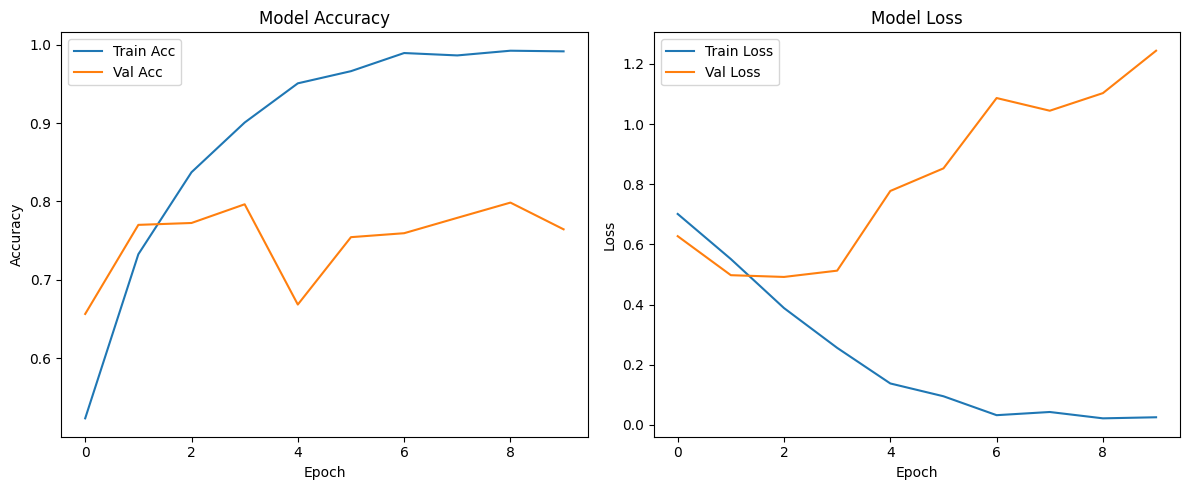

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

PLOT ROC CURVE

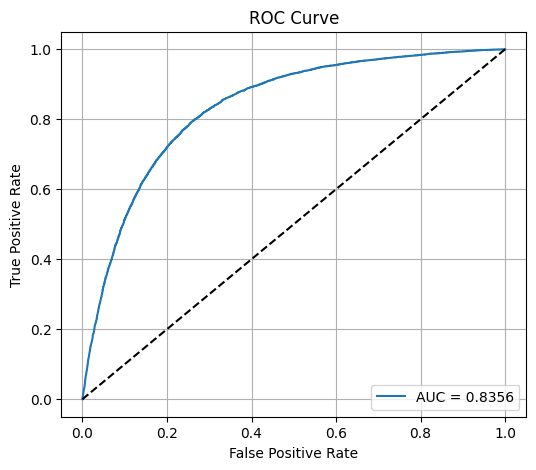

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
